# Скользящее окно (фильтр)

Можно не подавать на вход нейрона первого слоя информацию о всем изображении сразу, а "показать" ему только часть картинки, чтобы он научился распознавать простые, но универсальные паттерны. А их агрегация произойдет в последующих слоях.

Для этого используется так называемое "скользящее окно", которое двигается по изображению, захватывая на каждом шаге только небольшую область.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/convolution_with_filter_step1.png" width="600">


<font color=2BA8E0 size=30>0</font>
<font color=000000 size=30>×</font>
<font color=6aa84f size=30>6 </font>
<font color=000000 size=30>+ </font>
<font color=2BA8E0 size=30>1</font>
<font color=000000 size=30>×</font>
<font color=6aa84f size=30>7 </font>
<font color=000000 size=30>+ </font>
<font color=2BA8E0 size=30>3</font>
<font color=000000 size=30>×</font>
<font color=6aa84f size=30>8 </font>
<font color=000000 size=30>+ </font>
<font color=2BA8E0 size=30>4</font>
<font color=000000 size=30>×</font>
<font color=6aa84f size=30>9 </font>
<font color=000000 size=30>= </font>
<font color=38761d size=30>67</font>



<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/convolution_with_filter.gif" width="600">

### Фильтры размытия

Такой подход используют, например, при наложении графических **фильтров**. Вы наверняка пользовались ими, если работали в графических редакторах, например, в Photoshop.



Простейший фильтр — это [Box blur 📚[wiki]](https://en.wikipedia.org/wiki/Box_blur), который просто усредняет значения соседних пикселей.

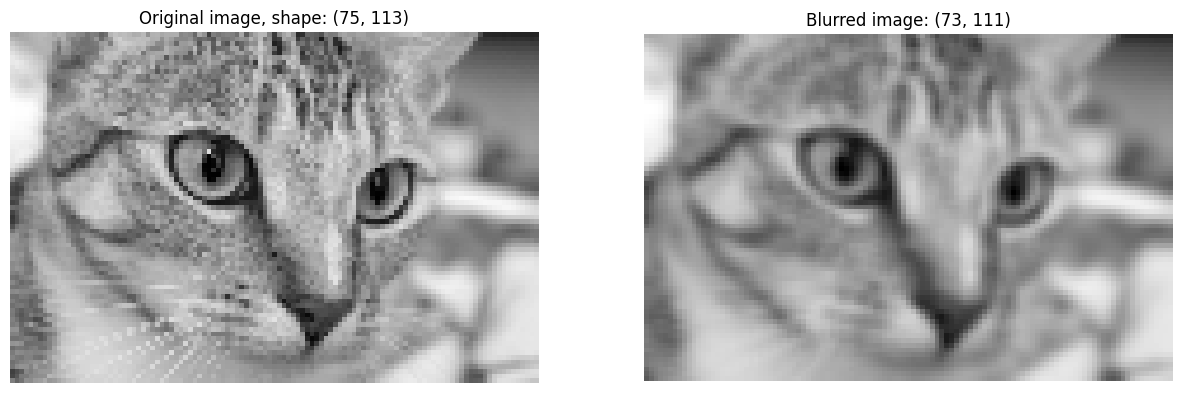

In [ ]:
from skimage import data, color
from skimage.transform import rescale
import numpy as np
import matplotlib.pyplot as plt


box_blur_kernel = 1/9 * np.array([[1, 1, 1],
                                  [1, 1, 1],
                                  [1, 1, 1]])


def apply_filter(img, kernel):
    h, w = np.array(img.shape)  # image height and width
    kh, kw = np.array(kernel.shape)  # kernel height and width (3x3)
    # calculate the output size, hard work ...
    out = np.zeros((h - kh + 1, w - kw + 1))
    for i in range(h - kh + 1):
        for j in range(w - kw + 1):
            # get 3x3 patch from image
            patch = img[i : i + kh, j : j + kw]
            # elementwise multiply patch pixels to kernel weights and sum
            new_pixel = np.multiply(patch, kernel).sum()
            # store modified pixel in new blurred image
            out[i, j] = new_pixel
    return out


def show(img, result):
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(img, cmap="gray")
    axes[1].imshow(out, cmap="gray")
    axes[0].set(title=f"Original image, shape: {img_cat_resc.shape}")
    axes[1].set(title=f"Blurred image: {out.shape}")
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()


img_cat = color.rgb2gray(data.cat())
img_cat_resc = rescale(img_cat, 0.25, anti_aliasing=False) * 255

out = apply_filter(img_cat_resc, box_blur_kernel)
show(img_cat_resc, out)

Можно умножать каждый пиксель на свой коэффициент. Так устроен, например, [фильтр Гаусса 📚[wiki]](https://en.wikipedia.org/wiki/Gaussian_blur).

Реализуем фильтр Гаусса размером $3\times3$ для размытия изображения:

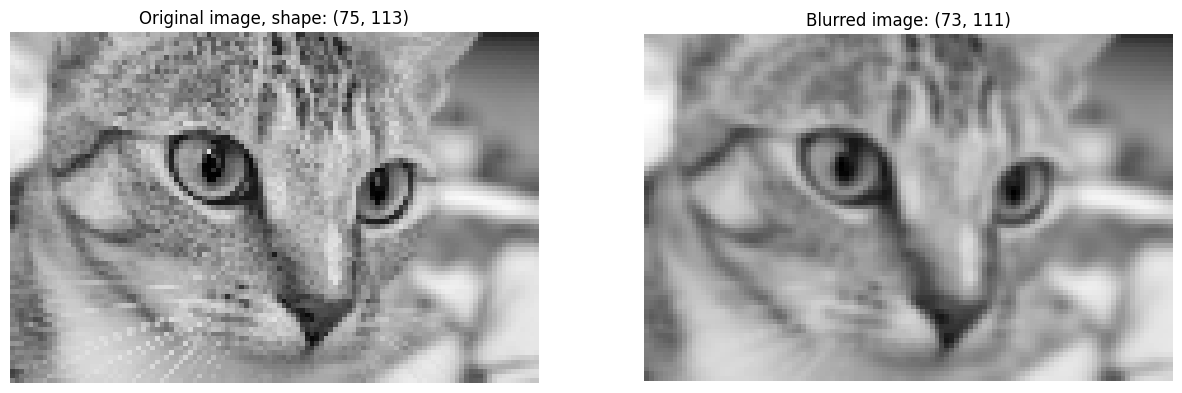

In [ ]:
# fmt: off
# Gaussian 3x3 kernel, sum of weights == 1
gauss_kernel = np.array([[1/16, 1/8, 1/16],
                         [1/8,  1/4, 1/8 ],
                         [1/16, 1/8, 1/16]])
# fmt: on

out = apply_filter(img_cat_resc, gauss_kernel)
show(img_cat_resc, out)

Последовательность действий:

*  Для каждого пикселя исходного изображения берем окрестность размером $3 \times 3$.
*  Значение каждого пикселя из этой окрестности умножаем на соответствующее значение из массива kernel (тоже $3 \times 3$).
*  Затем суммируем все 9 результатов, получившееся число записываем в новый массив.
* В результате получаем сглаженное изображение.

Таким образом, для получения нового изображения мы применили формулу:

$$\large \text{output}(x,y) =  \sum_{i}^{H} \sum_{j}^{W}k[i,j] I[x+j,y+i],$$

где $H, W$ — высота и ширина ядра фильтра, $I$ — исходное изображение.

**Если бы мы вытянули фрагменты картинки и ядро фильтра в вектора, а затем их скалярно перемножили, результат был бы тем же!**

### Фильтры для обнаружения паттернов

Такой же алгоритм можно применять не для сглаживания изображения, а для поиска (выделения) на нем чего-либо (например, контуров объектов). Для этого достаточно заменить ядро фильтра.

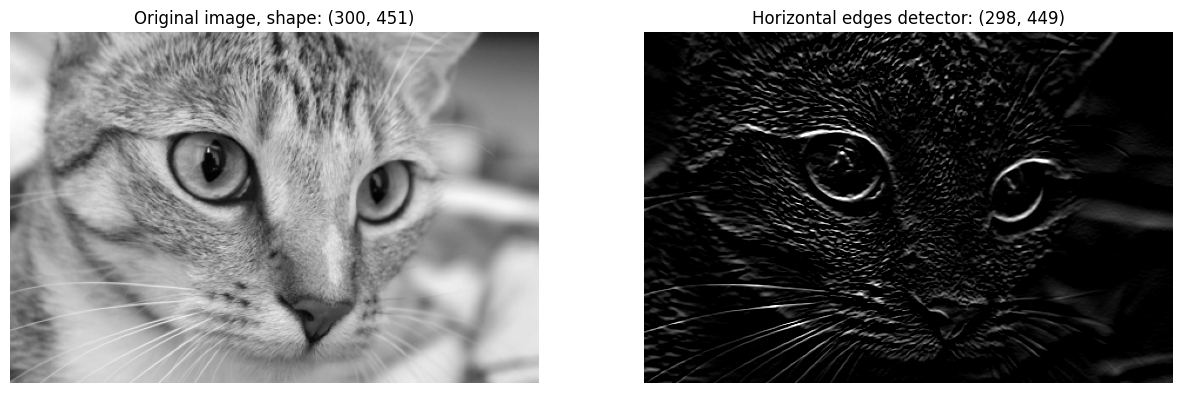

In [ ]:
import torch

sobel_y_kernel = torch.tensor([[ 1.0,  2.0, 1.0 ],
                               [ 0.0,  0.0, 0.0 ],
                               [-1.0, -2.0, -1.0]])

x_edges = apply_filter(img_cat * 255, sobel_y_kernel)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img_cat, cmap="gray")
axes[1].imshow(x_edges, cmap="gray", vmin=0, vmax=255)
axes[0].set(title=f"Original image, shape: {img_cat.shape}")
axes[1].set(title=f"Horizontal edges detector: {x_edges.shape}")
axes[0].axis("off")
axes[1].axis("off")
plt.show()

Мы применили к изображению [фильтр Cобеля 📚[wiki]](https://en.wikipedia.org/wiki/Sobel_operator), а точнее, одно из его ядер, дающее отклик на перепад яркости по вертикали.

"Отклик" — это величина яркости, которую мы получили на результирующем изображении.

Можно запрограммировать свой фильтр, который будет искать произвольный объект.
Например, найдем крест на на изображении:

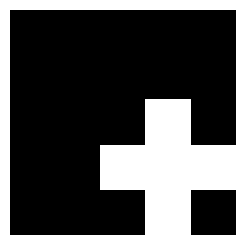

In [ ]:
cross = np.array([[0, 0 ,0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 0]])

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.axis("off")
plt.show()

Для этого создадим фильтр размером с объект ($3 \times 3$). В точках, где должны быть пиксели, принадлежащие объекту, поместим положительные значения, а там, где должен быть фон, — отрицательные.



In [ ]:
kernel_cs = np.array([[-1, 1, -1],
                      [ 1, 1,  1],
                      [-1, 1, -1]])

При попадании такого фильтра на объект отрицательные значения обнулятся при перемножении с пикселями фона, а положительные — просуммируются и дадут высокий отклик.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/cross_filter.png" width="900">


Проверим :

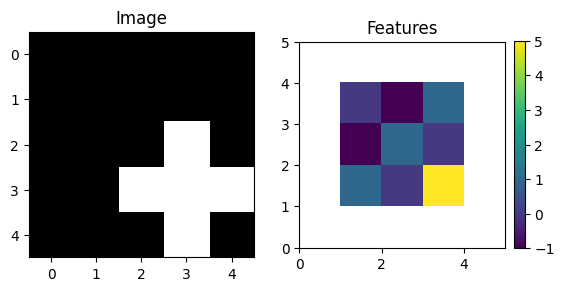

Features:
 [[ 0. -1.  1.]
 [-1.  1.  0.]
 [ 1.  0.  5.]]


In [ ]:
features = apply_filter(cross, kernel_cs)

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.imshow(features, extent=(1, 4, 1, 4))
plt.title("Features")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
print("Features:\n", features)

Такого рода фильтров люди придумали довольно много. Есть [детектор углов Харриса 📚[wiki]](https://en.wikipedia.org/wiki/Harris_Corner_Detector) или [признаки Хаара 📚[wiki]](https://en.wikipedia.org/wiki/Haar-like_feature), которые успешно использовались для [обнаружения лиц 📚[wiki]](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) на фотографиях. Это примеры случаев, когда людям удалось подобрать удачные ядра фильтров для решения конкретных задач.

Мы хотим, чтобы модель могла обучаться решать различные задачи. И вместо того, чтобы вручную создавать фильтры, мы будем подбирать их значения **в процессе обучения**.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/mlp_vs_cnn.png" width="1000">

Тогда модель сможет выучивать шаблоны для небольших фрагментов изображения и станет инвариантной к сдвигу.

# Свертка с фильтром

Операцию применения фильтра к изображению будем называть *сверткой*. Это определение не вполне соответствует [математическому 📚[wiki]](https://en.wikipedia.org/wiki/Convolution), но повсеместно используется в DL.

По своей сути операция свёртки — это та же самая взвешенная сумма с добавлением свободного члена, используемая в полносвязных линейных слоях.

В фильтрах Собеля и Гаусса свободный член осутствовал, но в дальнейшем мы будем его использовать.

Выполним свертку при помощи помощи линейного слоя: заменим код внутри цикла линейным слоем и убедимся, что результат вычислений не поменялся.

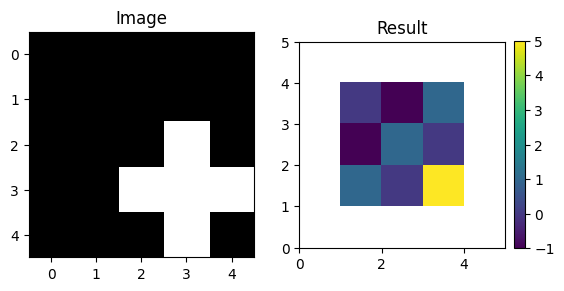

Result:
 tensor([[ 0., -1.,  1.],
        [-1.,  1.,  0.],
        [ 1.,  0.,  5.]])


In [ ]:
from torch import nn

local_linear = nn.Linear(9, 1, bias=False)  # 9 = 3 * 3 (weights shape: (3,3))

local_linear.weight.data[0] = torch.tensor(kernel_cs).flatten()  # Bad practice
cross_in_tensor = torch.tensor(cross).float()
result = torch.zeros((3, 3))
for i in range(0, result.shape[0]):
    for j in range(0, result.shape[1]):
        segment = cross_in_tensor[i : i + 3, j : j + 3].flatten()
        result[i, j] = local_linear(segment)

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.imshow(result.detach(), extent=(1, 4, 1, 4))

plt.title("Result")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
print("Result:\n", result.detach())

Ключевое отличие между линейным слоем и свёрткой заключается в том, что каждый нейрон линейного слоя получает на вход всё изображение сразу, а свёртка — небольшие фрагменты.

Так как при свертке для каждого фрагмента получаем свой отклик (признак), то для всего изображения получим уже массив признаков (feature map).




<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/neuron_output.png" width="700">

## Дополнительная информация

Рассмотрим, как выглядит операция свертки в функциональном анализе.

Есть две различные функции, определяющие локальную "схожесть" функций $f(t)$ и $g(t)$:
- взаимнокорреляционная функция обозначается пятиконечной звездой <font size="8">$\large ⋆$</font> и определяет схожесть двух функций:
$$(f ⋆ g)(t)\stackrel{def}{=}  \int\limits_{-\infty}^{\infty}  f(\tau)g(t+\tau)d\tau$$
- свертка обозначается звездочкой (астериском) <font size="8">$*$</font> и определяет схожесть одной функции и "отраженной" другой функции:
$$\large(f * g)(t)\stackrel{def}{=}  \int\limits_{-\infty}^{\infty}  f(\tau)g(t-\tau)d\tau$$

Взаимная корреляция более интуитивно понятна: она представляет собой "наложение" шаблона на функцию, а свертка &mdash; "наложение" отраженного шаблона. Эти функции взаимосвязаны:
$$f(t) ⋆ g(t) = f(-t) * g(t)$$

Можно представить свертку как площадь произведения двух функций внутри скользящего окна, как на анимации ниже.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/1d_convolution.gif" width="700">

В машинном обучении под словом **convolution** как правило [подразумевают **взаимнокорреляционную функцию** ✏️[blog]](https://glassboxmedicine.com/2019/07/26/convolution-vs-cross-correlation/), а не свертку. В реальности при обучении нейронной сети совершенно неважно, используется ли свертка или взаимнокорреляционная функция — они отличаются лишь порядком расположения весов внутри тензора ядра.

В случае дискретных величин для вычисления взаимной корреляции сигнал $f(t)$ поэлементно умножается со смещенным ядром $g(t)$, и результат суммируется:

$$\large(f \star g)(t) = f(1)g(t+1) + f(2)g(t+2) + f(3)g(t+3) + ...$$